<a href="https://colab.research.google.com/github/gregueiras/7052CEM/blob/master/ff_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from src.projects import Projects
from src.experiments import SIMBED_Experiments, SIMBEDP_Experiments, get_nodes
from src.node_location import get_location, get_distance
from src.experimentCFG import get_configs, ExperimentCFG
from src.util import load_data_path
from src.util_rss import load_rss
from src.path_loss import friis, log_distance, gammas
from src.util_ai import cv, plot_prediction, scatter_distance, evaluate_model, wrap_keras, wrap_sklearn
from src.models import baseline_model, n1
from src.final import full_pipeline, fast_fading_model
from src.fast_fading import plot_best_distributions, best_fit_distribution
from datetime import datetime
from typing import List
import os
from IPython.display import display

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import TransformedTargetRegressor
import itertools

from math import sqrt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import TensorBoard

import xgboost as xg

plt.rcParams['figure.figsize'] = [15, 8]
ML_KEY = "TS-ML"

In [2]:
proj = Projects.SIMBED
exp = SIMBED_Experiments._3

cfgs = get_configs(project=proj, experiment=exp)
data = load_rss(cfgs, 0.2, sec_avg=False)

display(data.head())

,distance,friis,log_d_1.7,log_d_2.0,log_d_2.5,PL
0,5.85730,-62.149132,-65.846039,-62.149132,-55.987617,-71.0
1,6.91885,-63.595860,-67.075760,-63.595860,-57.796032,-70.0
2,2.28478,-53.972069,-58.895538,-53.972069,-45.766293,-67.0
3,5.00069,-60.775780,-64.678688,-60.775780,-54.270931,-69.0
4,2.27958,-53.952278,-58.878716,-53.952278,-45.741554,-71.0


In [3]:
df_means = data.groupby("distance").mean()
for i in df_means.index:
    data.loc[data.distance == i, "PL"] -= df_means.loc[i]["PL"]

sse: norm_gen	0.04729019335762314
sse: rice_gen	0.16144163010714999
sse: rayleigh_gen	0.5731884934273954


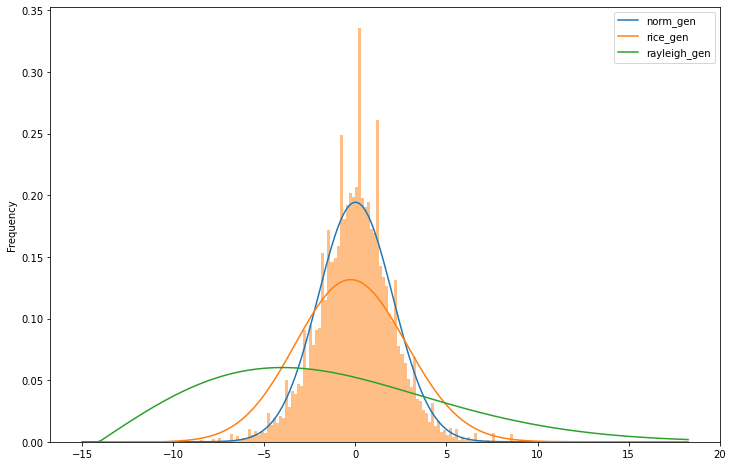

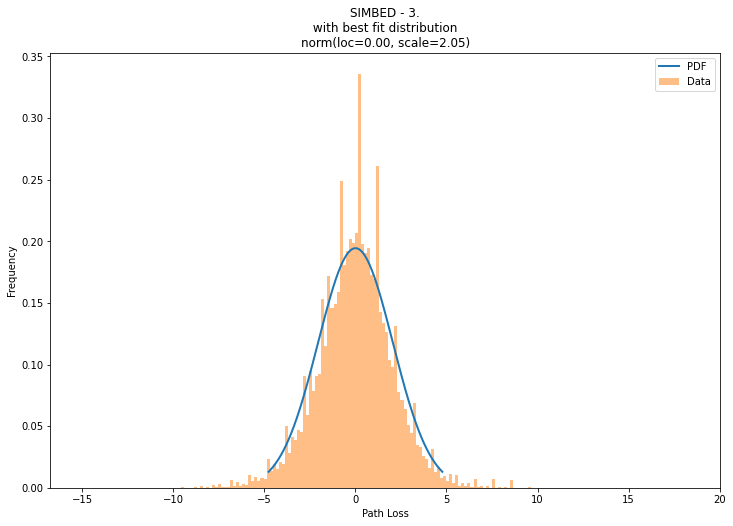

<Figure size 864x576 with 0 Axes>

In [4]:
plot_best_distributions(proj, exp, data["PL"], bins=200)

In [5]:
model = fast_fading_model("AAA", data, rebuild=True)

model(10)

sse: norm_gen	0.04728861615545711
sse: rice_gen	0.16144502949721684
sse: rayleigh_gen	0.5731771469361036


array([ 1.01908932, -0.28367153,  1.32883765,  3.12474172, -0.48040344,
       -0.48036976,  3.24001014,  1.5745163 , -0.9632025 ,  1.11314957])